In [32]:
import numpy as np
import sounddevice as sd
import subprocess
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from os import listdir
from os.path import isdir, join

In [36]:

# Charger le modèle TFLite
interpreter = tf.lite.Interpreter(model_path='all_targets.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Filenames to test
# filename  = '../data_speech_commands_v0.02/four/0a2b400e_nohash_0.wav'  #Four
# filename  = '../data_speech_commands_v0.02/right/0a2b400e_nohash_3.wav' #Right
filename  = '../data_speech_commands_v0.02/stop/0a196374_nohash_0.wav'  #Stop

dataset_path = '../data_speech_commands_v0.02'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')

# Définir les paramètres du traitement du signal
sample_rate = 8000  # Définir la fréquence d'échantillonnage appropriée
audio_duration = 1  # Durée de l'audio en secondes
num_mfcc = 16  # Nombre de coefficients MFCC à extraire

# Fonction pour calculer les coefficients MFCC à partir du signal audio
def calc_mfcc_from_C(path):
    
    #Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    signal=signal*(2**15)
    function=signal.astype(np.int16)
    #Stock the Wav data in the file time_series.dat
    np.savetxt('./time_series_1s.dat', function, fmt='%d', delimiter='\n') 
    
    # Call the C++ function to compute the MFCC from the time series
    subprocess.run(["./compute_mfcc"], shell=True)

    # Load the MFCC from the file mfcc_from_time_series.dat
    mfcc_from_time_series = np.genfromtxt('mfcc_from_time_series_1s.dat',delimiter='\n',dtype=None)
    mfcc_from_time_series = mfcc_from_time_series.reshape(16,16)
    
    return mfcc_from_time_series

# Fonction pour effectuer une prédiction avec le modèle TFLite
def predict(input_data):
    input_shape = input_details[0]['shape']
    input_data =input_data.reshape(input_shape).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)
    probability = np.max(output_data)
    return predicted_class, probability



../data_speech_commands_v0.02/stop/0a196374_nohash_0.wav


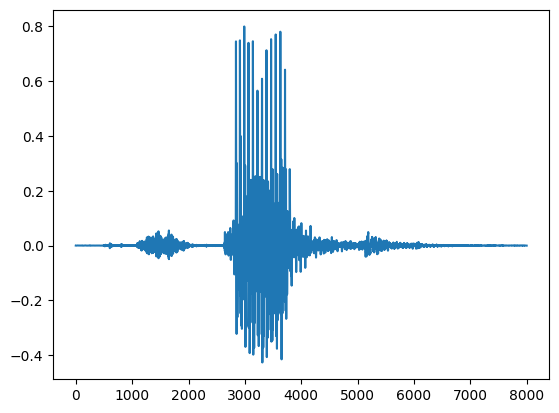

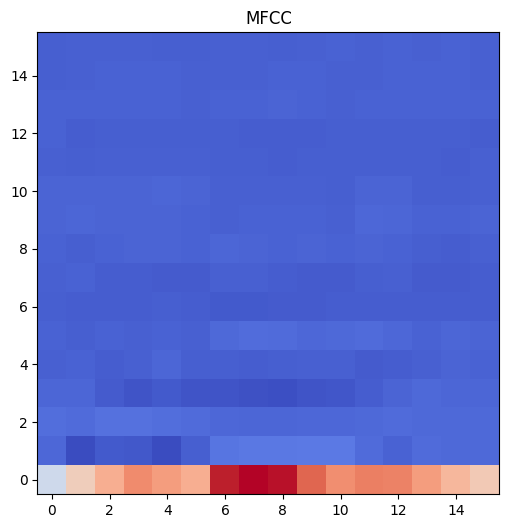

In [30]:
mfccs = calc_mfcc_from_C(filename)
print(filename)

# Signal
signal, fs = librosa.load(filename, sr=8000)
plt.plot(signal)

# MFCC
mfcc_from_time_series = mfccs.reshape(16,16)
fig, ax = plt.subplots(figsize=(6,6))
mfcc_from_time_series= np.swapaxes(mfcc_from_time_series, 0 ,1)
cax = ax.imshow(mfcc_from_time_series, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()


In [39]:
processed_data = calc_mfcc_from_C(filename)
predicted_class, probability = predict(processed_data)
print('Prédiction :', all_targets[predicted_class], '->', probability)

Prédiction : stop -> 0.86008847
